# CRAFTY Web Scraping. Flavio Romano, 614801

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

"""Datasets"""
transactions = pd.read_csv("./datasets/transactions.csv", names=["timestamp", "blockId", "txId", "isCoinbase", "fee"])
inputs = pd.read_csv("./datasets/inputs.csv", names=["txId", "prevTxId", "prevTxPos"])
outputs = pd.read_csv("./datasets/outputs.csv", names=["txId", "position", "addressId", "amount", "scriptType"])
mapping_df = pd.read_csv("./datasets/mapAddr2Ids8708820.csv", names=["hash", "addressId"])

transactions['timestamp'] = pd.to_datetime(transactions['timestamp'], unit='s')

### Analisi generali sui dati

In [65]:
print(transactions.head())
print(inputs.head())
print(outputs.head())
print(mapping_df.head())

            timestamp  blockId  txId  isCoinbase  fee
0 2009-01-09 03:54:39        9     9           1    0
1 2009-01-11 01:00:54       78    78           1    0
2 2009-01-12 03:30:25      170   171           0    0
3 2009-01-12 06:02:13      181   183           0    0
4 2009-01-12 06:12:16      182   185           0    0
   txId  prevTxId  prevTxPos
0   171         9          0
1   183       171          1
2   185       183          1
3   187       185          1
4   192       187          0
   txId  position  addressId      amount  scriptType
0     9         0          9  5000000000           1
1    78         0         78  5000000000           1
2   171         0        171  1000000000           1
3   171         1          9  4000000000           1
4   183         0        183  1000000000           1
                                 hash  addressId
0  1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa          0
1  12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX          1
2  1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1

### Distribuzione del numero di transazioni per blocco (occupazione del blocco), nell’intero periodo temporale considerato

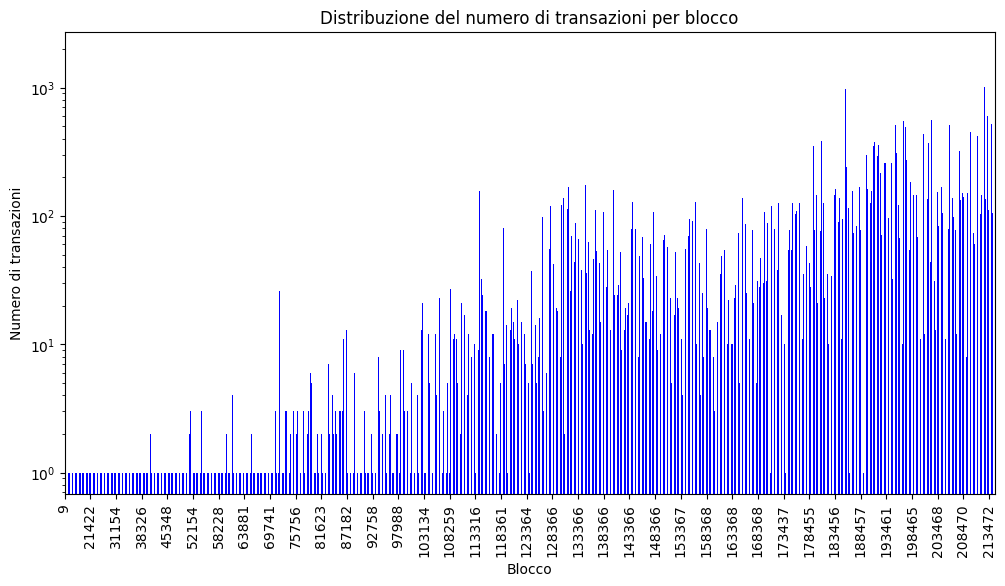

In [24]:
transactions_per_block = transactions.groupby("blockId")["txId"].count()

plt.figure(figsize=(12,6))
transactions_per_block.plot(kind="bar", color="blue")
plt.xlabel("Blocco")
plt.ylabel("Numero di transazioni")
plt.title("Distribuzione del numero di transazioni per blocco")

plt.yscale("log")

x_ticks = range(0, len(transactions_per_block), 5000)
plt.xticks(x_ticks, transactions_per_block.index[x_ticks])

plt.show()

### Evoluzione dell'occupazione dei blocchi nel tempo

01-01-09


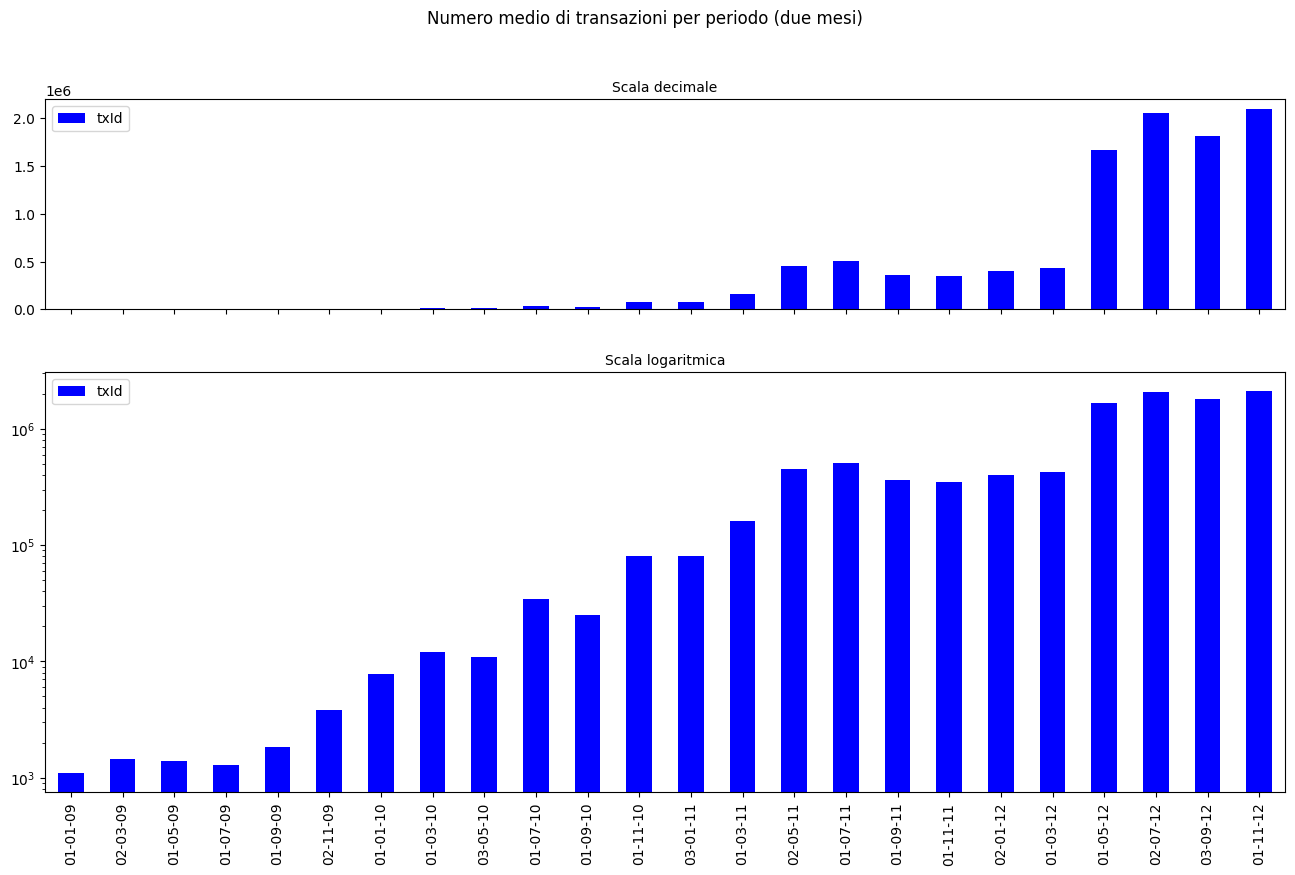

In [59]:
avg_transactions_per_period = transactions[["timestamp", 'txId']].resample(
    '2BMS', on="timestamp").count()

avg_transactions_per_period.index = [date.strftime("%d-%m-%y") for date in avg_transactions_per_period.index]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(
    16, 9), gridspec_kw={'height_ratios': [1, 2]})
fig.suptitle("Numero medio di transazioni per periodo (due mesi)")
avg_transactions_per_period.plot(ax=axes[0], kind="bar", color="blue")
axes[0].set_title("Scala decimale", fontsize=10)

print(avg_transactions_per_period.index[0])

avg_transactions_per_period.plot(ax=axes[1], kind="bar", color="blue")
axes[1].set_title("Scala logaritmica", fontsize=10)
plt.yscale("log")

plt.show()

### Ammontare totale degli UTXO al momento dell’ultima transazione

In [110]:
# output che sono stati input di una transazione
temp = outputs.merge(inputs, how='inner', left_on=["txId", "position"], right_on=["prevTxId", "prevTxPos"])
utxo = outputs.amount.sum() - temp.amount.sum()
print(utxo)  #  859303372614879

859303372614879


### Distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un valore in output e quella che lo consuma

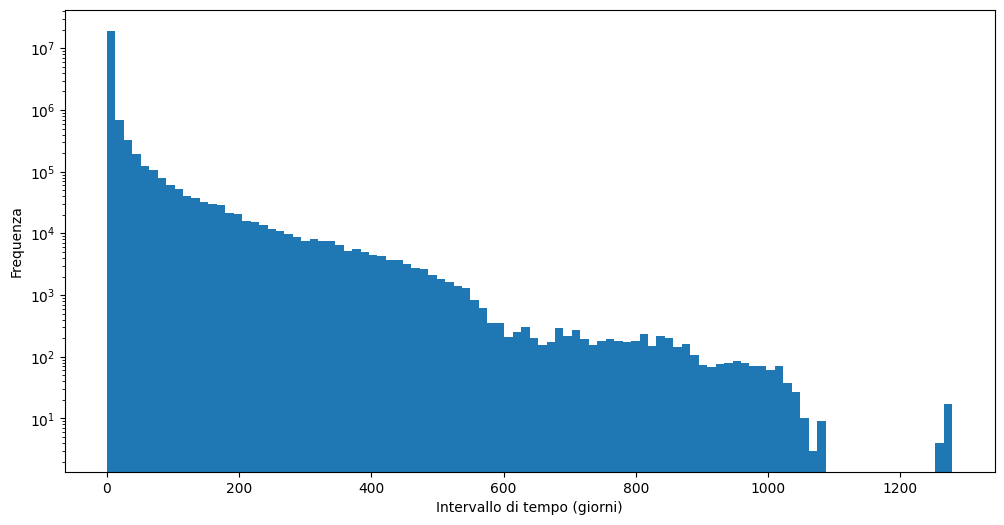

In [247]:
spent = transactions.merge(inputs, on="txId").rename(columns={"timestamp": "timestamp_spent"})[["timestamp_spent", "txId", "prevTxId", "prevTxPos"]]
created = transactions.merge(outputs, on="txId").rename(columns={"timestamp": "timestamp_created"})[["timestamp_created", "txId", "position"]]

diff = spent.merge(created.rename(columns={"txId": "outTxId"}), how="inner", left_on=["prevTxId", "prevTxPos"], right_on=["outTxId", "position"])[["timestamp_created", "timestamp_spent"]]
diff["timestamp_difference"] = (diff.timestamp_spent - diff.timestamp_created).dt.days
diff.drop(diff[diff.timestamp_difference < 0].index, inplace=True) # rimuovo inconsistenze

plt.figure(figsize=(12, 6))
plt.hist(diff[["timestamp_difference"]], bins=100)
plt.yscale("log")
plt.xlabel("Intervallo di tempo (giorni)")
plt.ylabel("Frequenza")
plt.show()

### A scelta: Evoluzione dei 3 address più ricchi (whales)

In [214]:
temp = (~outputs["txId"].isin(inputs["prevTxId"]))
utxo = outputs.loc[temp][["addressId", "amount", "txId"]]
utxo_address = utxo.groupby(by="addressId").sum("amount").sort_values(by="amount", ascending=False)[["amount"]]
top_5_utxo = utxo_address.head(5).merge(mapping_df, how="inner", left_index=True, right_on="addressId").drop(columns=["addressId"])

address1, address2, address3, address4, address5 = top_5_utxo.index
print(top_5_utxo)


                amount                                hash
2770941  4972966980000  13vJZKHKBirruXwmjMaRtakzPQRRHQit1S
1083446  4716866106997  1933phfhK3ZgFQNLGSDXvqCn32k2buXY8a
6755311  4000000000000  1BqcwhKevdBKeos72b8E32Swjrp4iDVnjP
8693203  3078426899989  14f6ZV83eke4DQsqTQsGaNrMNvHmwCm59t
4211569  2859999380000  139Vxkqcrs5fB9JvZcBzKuPwqsoVwisykJ


In [263]:
utxo_address1 = utxo.loc[utxo.addressId == address1].merge(transactions, on="txId")[["addressId", "amount", "timestamp"]]
utxo_address2 = utxo.loc[utxo.addressId == address2].merge(transactions, on="txId")[["addressId", "amount", "timestamp"]]
utxo_address3 = utxo.loc[utxo.addressId == address3].merge(transactions, on="txId")[["addressId", "amount", "timestamp"]]
utxo_address4 = utxo.loc[utxo.addressId == address4].merge(transactions, on="txId")[["addressId", "amount", "timestamp"]]
utxo_address5 = utxo.loc[utxo.addressId == address5].merge(transactions, on="txId")[["addressId", "amount", "timestamp"]]

#### Plottiamo 

                              utxo
timestamp                         
2011-07-02 02:42:15  4095456541907
2011-08-02 13:00:03  4151044391907
2011-09-27 20:24:30  4171044391907
2012-09-20 19:05:31  4176060849407
2012-09-21 01:02:08  4176160849407
2012-09-21 01:43:04  4176281849407
2012-11-15 02:59:57  4383351188822
2012-11-15 05:17:03  4716866106997


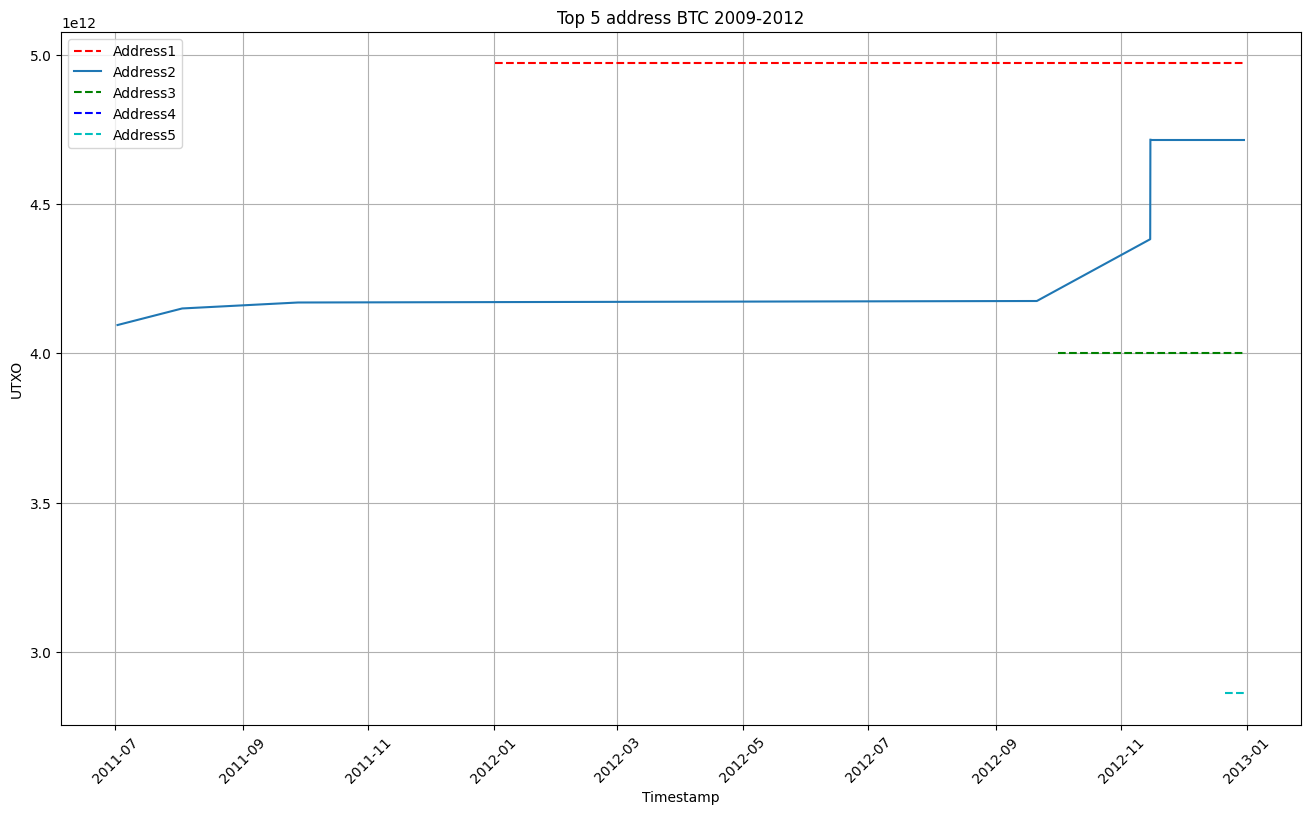

In [264]:
df_silkRoad = pd.DataFrame()
df_silkRoad.index = utxo_address2.timestamp
df_silkRoad["utxo"] = 0

for date in df_silkRoad.index:
    df_silkRoad.at[date, "utxo"] = utxo_address2.loc[utxo_address2["timestamp"] <= date].amount.sum()

timestamp_max = max(utxo_address1.timestamp.max(),
                    utxo_address2.timestamp.max(),
                    utxo_address3.timestamp.max(),
                    utxo_address4.timestamp.max(),
                    utxo_address5.timestamp.max())

print(df_silkRoad)

plt.figure(figsize=(16, 9))

plt.hlines(y=top_5_utxo.loc[address1].amount,color='r', linestyle='--', label='Address1', xmin=utxo_address1.timestamp, xmax=timestamp_max)

plt.plot(df_silkRoad.index, df_silkRoad['utxo'], label="Address2")
plt.hlines(y=df_silkRoad.loc[max(df_silkRoad.index)], xmin=max(df_silkRoad.index), xmax=timestamp_max)

plt.hlines(y=top_5_utxo.loc[address3].amount, color='g', linestyle='--', label='Address3', xmin=utxo_address3.timestamp, xmax=timestamp_max)

plt.hlines(y=top_5_utxo.loc[address4].amount, color='b', linestyle='--', label='Address4', xmin=utxo_address4.timestamp, xmax=timestamp_max)

plt.hlines(y=top_5_utxo.loc[address5].amount, color='c', linestyle='--', label='Address5', xmin=utxo_address5.timestamp, xmax=timestamp_max)

plt.xlabel('Timestamp')
plt.ylabel('UTXO')
plt.title('Top 5 address BTC 2009-2012')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc="upper left")

plt.show()